## Jupyter Notebook pour le sujet Kaggle "Bike Sharing Demand"

## Alexandre Chevaux Matthieu Garrigue

### Importation des bibliothèques

In [1]:
import pandas as pd
import sklearn as skl
import sklearn.model_selection as skl_model_selection
import sklearn.linear_model as skl_linear_mdl
import sklearn.ensemble as skl_ensemble_mdl
import sklearn.discriminant_analysis as skl_discriminant_analysis
import sklearn.metrics as skl_metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import xgboost as xgb
import seaborn as sns
from statistics import mean 
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from pandas import Series
from matplotlib import pyplot

## Importation et description du dataset

In [4]:
##Importation des fichiers
df_bike_train = pd.read_csv(r"train.csv")
df_bike_test = pd.read_csv(r"test.csv")
df_bike_test["registered"]=0
df_bike_test["casual"]=0
df_bike_test["count"]=0

In [5]:
df_bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Analyse préalable des données

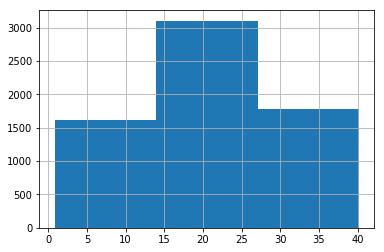

In [6]:
df_bike_test["temp"].hist(bins=3)

Corrélations entre temp et atemp:0.98


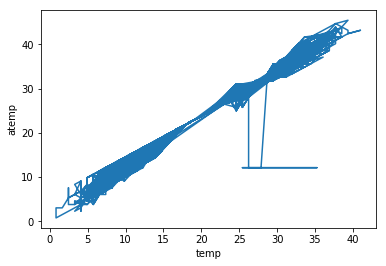

In [8]:
plt.plot(df_bike_train["temp"],df_bike_train["atemp"])
plt.xlabel("temp")
plt.ylabel("atemp")
print("Corrélations entre temp et atemp:" + str(round(df_bike_train["temp"].corr(df_bike_train["atemp"]),2)))

In [9]:
df_combine = [df_bike_train, df_bike_test]

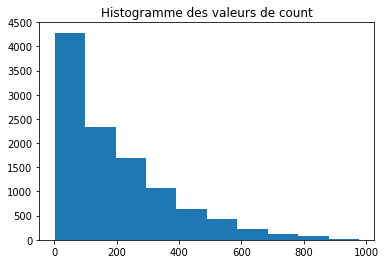

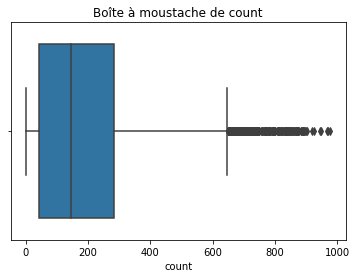

In [10]:
##Analyse de la varaible de sortie
plt.hist(df_bike_train["count"])
plt.title("Histogramme des valeurs de count")
plt.show()


sns.boxplot(df_combine[0]['count'])
plt.title("Boîte à moustache de count")
plt.show()

Text(0,0.5,'Somme des vélos vendus')

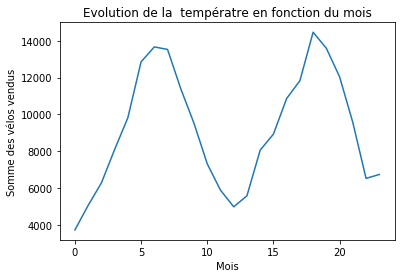

In [11]:
df_bike_train["nbr_day"]=1
df_bike_train['Year'] = pd.DatetimeIndex(df_bike_train["datetime"]).year
df_bike_train['Month'] = pd.DatetimeIndex(df_bike_train["datetime"]).month
x=df_bike_train.groupby(['Year','Month']).sum()
lst=[]
for i in x["temp"]:
    lst.append(i)
plt.plot(lst)
plt.title("Evolution de la  températre en fonction du mois")
plt.xlabel("Mois")
plt.ylabel("Somme des vélos vendus")



### Suppression de la saisonnalité 

Coefficients: [-3.06378331e-21  2.67114400e-17  4.17815112e-13 -5.82847541e-09
  2.20189717e-05 -2.53237491e-02  2.39987762e+01]


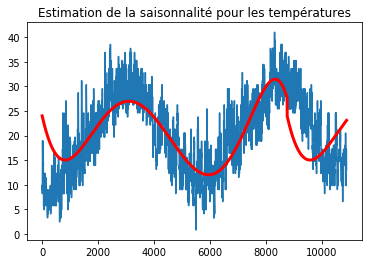

In [13]:

series = Series(df_bike_train["temp"])
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%(365*24) for i in range(0, len(series))]
y = series.values
degree = 6
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.title("Estimation de la saisonnalité pour les températures")
pyplot.show()


Coefficients: [-3.06378331e-21  2.67114400e-17  4.17815112e-13 -5.82847541e-09
  2.20189717e-05 -2.53237491e-02  2.39987762e+01]


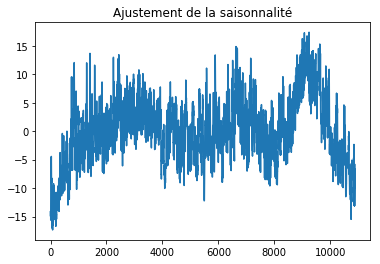

In [14]:

series = Series(df_bike_train["temp"])
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%(365*24) for i in range(0, len(series))]
y = series.values
degree = 6
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# create seasonally adjusted
values = series.values
diff = list()
for i in range(len(values)):
	value = values[i] - curve[i]
	diff.append(value)
pyplot.plot(diff)
pyplot.title("Ajustement de la saisonnalité")
pyplot.show()

Text(0,0.5,'Somme des vélos vendus')

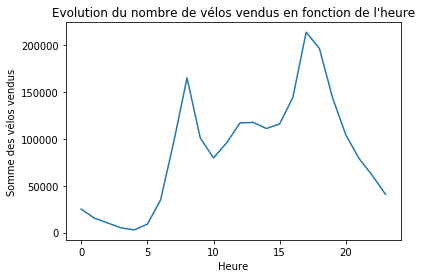

In [15]:
df_bike_train["nbr_day"]=1
df_bike_train['Hour'] = pd.DatetimeIndex(df_bike_train["datetime"]).hour
x=df_bike_train.groupby(['Hour']).sum()
lst=[]
for i in x["count"]:
    lst.append(i)
 
plt.plot(lst)
plt.title("Evolution du nombre de vélos vendus en fonction de l'heure")
plt.xlabel("Heure")
plt.ylabel("Somme des vélos vendus")


[Text(0,0.5,'Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'vélos loués en fonction des heures du jour')]

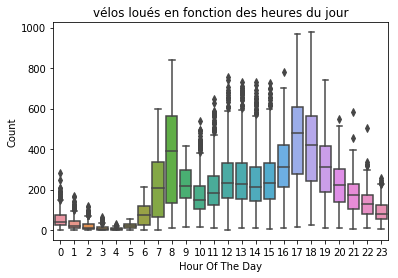

In [16]:
#Boite à moustache des vélos loués en fonction des heures du jours:
import seaborn as sn
sn.boxplot(x=df_bike_train['Hour'],y="count",data=df_bike_train,orient="v").set(xlabel='Hour Of The Day', ylabel='Count',title="vélos loués en fonction des heures du jour")
#sns.swarmplot(x=df_bike_train['Hour'], y="count", data=df_bike_train, color=".25")

[Text(13.175,0.5,'Count'),
 Text(0.5,-10.2,'Hour Of The Day'),
 Text(0.5,1,'occasionnels')]

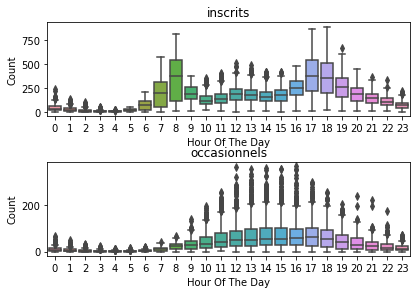

In [17]:
# boite à moustache en distinguant les individus inscrits des individus non inscrits
#fig = plt.subplots(nrows=1,ncols=2)
#fig.set_size_inches(12, 10)
plt.subplot(2,1,1)
plt.tight_layout()
sn.boxplot(x=df_bike_train['Hour'],y="registered",data=df_bike_train,orient="v").set(xlabel='Hour Of The Day', ylabel='Count',title="inscrits")
plt.subplot(2,1,2)
plt.tight_layout()
sn.boxplot(x=df_bike_train['Hour'],y="casual",data=df_bike_train,orient="v").set(xlabel='Hour Of The Day', ylabel='Count',title="occasionnels")

## Features Engineering

In [18]:
#features engineering
from sklearn import preprocessing
df_bike_train = pd.read_csv(r"train.csv")
df_bike_test = pd.read_csv(r"test.csv")
df_bike_test["registered"]=0
df_bike_test["casual"]=0
df_bike_test["count"]=0
df_combine = [df_bike_train, df_bike_test]

i=0
for df_bike_sharing in df_combine:
    #df_bike_sharing.drop(columns="atemp")
    if i==0:
        df_bike_sharing['count']=df_bike_sharing['count'].apply(lambda x:np.log(x))
        df_bike_sharing['registered']=df_bike_sharing['registered'].apply(lambda x:np.log(x+1)) #+1 pour négocier les valeures nulles
        df_bike_sharing['casual']=df_bike_sharing['casual'].apply(lambda x:np.log(x+1)) #+1 pour négocier les valeurs nulles
        #train_df['count']=boxcox(train_df['count'])[0]
    #df_bike_sharing["Year"]=0
    #print(df_bike_sharing.head())
    df_bike_sharing['Year'] = pd.DatetimeIndex(df_bike_sharing["datetime"]).year
    df_bike_sharing['Month'] = pd.DatetimeIndex(df_bike_sharing["datetime"]).month
    df_bike_sharing['Wday'] = pd.DatetimeIndex(df_bike_sharing["datetime"]).weekday
    df_bike_sharing['Week'] = pd.DatetimeIndex(df_bike_sharing["datetime"]).week
    df_bike_sharing['Day'] = pd.DatetimeIndex(df_bike_sharing["datetime"]).day
    df_bike_sharing["Hour"]= pd.DatetimeIndex(df_bike_sharing["datetime"]).hour
    
    """
    df_bike_sharing['15h'] = np.where((df_bike_sharing['Hour']==15), 1, 0)*(np.where(df_bike_sharing['workingday']==1,0,1 ))
    df_bike_sharing['16h']= np.where((df_bike_sharing['Hour']==16), 1, 0)*(np.where(df_bike_sharing['workingday']==1,0,1 ))
    df_bike_sharing['14h']= np.where((df_bike_sharing['Hour']==14), 1, 0)*(np.where(df_bike_sharing['workingday']==1,0,1 ))
    df_bike_sharing['Rush_Hour']=df_bike_sharing['15h']+df_bike_sharing['16h']+df_bike_sharing['14h']
    df_bike_sharing.drop(['16h','15h','14h'], axis=1)
    #print(df_bike_sharing['Rush_Hour'].head(50))
    """
    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['weather'])
    df_bike_sharing = df_bike_sharing.drop(labels='weather_4', axis=1)
    
    
    df_bike_sharing['temp_weath_1'] = df_bike_sharing['temp'] * df_bike_sharing['weather_1']
    df_bike_sharing['temp_weath_2'] = df_bike_sharing['temp'] * df_bike_sharing['weather_2']
    df_bike_sharing['temp_weath_3'] = df_bike_sharing['temp'] * df_bike_sharing['weather_3']
    
    
    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['holiday'])
    #df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['workingday'])
    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['season'])
    
    
    ###Code pour normaliser des colonnes mais on obtient un moins bon score Kaggle pour la RF regression
    #column_names_to_normalize = ['humidity', 'atemp', 'temp']
    """"
    column_names_to_normalize = ['temp','humidity']
    x = df_bike_sharing[column_names_to_normalize].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df_bike_sharing.index)
    df_bike_sharing[column_names_to_normalize] = df_temp
    """
    ###Création de dummies pour les colonnes de float
    """
    cpt_row=0
    for row_bike_sharing in df_bike_sharing["humidity"]:
        if row_bike_sharing==0 :
                df_bike_sharing.loc[[cpt_row], ['humidity']]=0
        if row_bike_sharing<45 and row_bike_sharing!=0 :
                df_bike_sharing.loc[[cpt_row], ['humidity']]=1
        if row_bike_sharing<60 and row_bike_sharing>=45 :
                df_bike_sharing.loc[[cpt_row], ['humidity']]=2
        if row_bike_sharing>=60 :
                df_bike_sharing.loc[[cpt_row], ['humidity']]=3
        cpt_row=cpt_row+1
        
    cpt_row=0
    for row_bike_sharing in df_bike_sharing["atemp"]:
        if row_bike_sharing<19 :
                df_bike_sharing.loc[[cpt_row], ['atemp']]=0
        if row_bike_sharing<32 and row_bike_sharing>=19 :
                df_bike_sharing.loc[[cpt_row], ['atemp']]=1
        if row_bike_sharing>=32 :
                df_bike_sharing.loc[[cpt_row], ['atemp']]=2
        cpt_row=cpt_row+1
    
    cpt_row=0
    for row_bike_sharing in df_bike_sharing["temp"]:
        if row_bike_sharing<15 :
                df_bike_sharing.loc[[cpt_row], ['temp']]=0
        if row_bike_sharing<26 and row_bike_sharing>=15 :
                df_bike_sharing.loc[[cpt_row], ['temp']]=1
        if row_bike_sharing>=26 :
                df_bike_sharing.loc[[cpt_row], ['temp']]=2
        cpt_row=cpt_row+1

    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['humidity'])
    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['atemp'])
    df_bike_sharing = pd.get_dummies(df_bike_sharing, columns=['temp'])

    """
    ##########################################

    #partie engineering à utiliser si on fait le calcul en estimant les registered et les casuals
    df_bike_sharing['daypart_registered']=Series(np.ones(len(df_bike_sharing)), index=df_bike_sharing.index, dtype=object)
    df_bike_sharing['daypart_casual']=Series(np.ones(len(df_bike_sharing)), index=df_bike_sharing.index,dtype=object)

    #Pour les individus enregistrés
    df_bike_sharing.loc[(df_bike_sharing['Hour']>=22)  | (df_bike_sharing['Hour']==0),'daypart_registered']=0
    df_bike_sharing.loc[(df_bike_sharing['Hour']>= 1)  & (df_bike_sharing['Hour']<=5),'daypart_registered']=1
    df_bike_sharing.loc[(df_bike_sharing['Hour']==6) 
                        | ((df_bike_sharing['Hour']>=10) & (df_bike_sharing['Hour']<=15)) 
                        | (df_bike_sharing['Hour']==20) 
                        | (df_bike_sharing['Hour']==21)
                       ,'daypart_registered']=2
    df_bike_sharing.loc[(df_bike_sharing['Hour']==7),'daypart_registered']=3
    df_bike_sharing.loc[(df_bike_sharing['Hour']==8),'daypart_registered']=4
    df_bike_sharing.loc[(df_bike_sharing['Hour']==17)  | (df_bike_sharing['Hour']==18),'daypart_registered']=5
    df_bike_sharing.loc[(df_bike_sharing['Hour']==9)  
                        |(df_bike_sharing['Hour']==16)  
                        | (df_bike_sharing['Hour']==19)
                        ,'daypart_registered']=6

    # Pour les occasionnels
    df_bike_sharing.loc[(df_bike_sharing['Hour']>=23)  | (df_bike_sharing['Hour']<=7),'daypart_casual']=0
    df_bike_sharing.loc[(df_bike_sharing['Hour']== 8) 
                        | (df_bike_sharing['Hour']==9)
                        | (df_bike_sharing['Hour']==21)
                        | (df_bike_sharing['Hour']==22)
                    ,'daypart_casual']=1
    df_bike_sharing.loc[(df_bike_sharing['Hour']>=10) & (df_bike_sharing['Hour']<=20),'daypart_casual']=2
    #pd.Series(df_bike_sharing.daypart_registered, dtype='int32')
    #pd.Series(df_bike_sharing.daypart_casual, dtype='int32')
    ##########################################
 
    series = Series(df_bike_sharing["temp"])
    # fit polynomial: x^2*b1 + x*b2 + ... + bn
    X = [i%(365*24) for i in range(0, len(series))]
    y = series.values
    degree = 8
    coef = np.polyfit(X, y, degree)
    # create curve
    curve = list()
    for j in range(len(X)):
        value = coef[-1]
        for d in range(degree):
            value += X[j]**(degree-d) * coef[d]
        curve.append(value)
    # create seasonally adjusted
    values = series.values
    diff = list()
    for j in range(len(values)):
        value = values[j] - curve[j]
        diff.append(value)
    df_bike_sharing["temp"]=diff

    df_combine[i]=df_bike_sharing
    i=1
    




# Neural Networks

In [19]:
X=df_combine[0]
Y =df_combine[0]["count"]
#on  définie les features qui vont être intéressants pour la prédiction
features=X.columns.values
features=list(features)
features.remove("datetime")
features.remove("daypart_casual")
features.remove("daypart_registered")
features.remove("casual")
features.remove("registered")
features.remove("count")

X_train = df_combine[0]
Y_train = df_combine[0]["count"]
X_test = df_combine[1]
X=X_train[features]
Y=X_train['count']
X_testNN=X_test[features]

In [20]:
#split des données
from sklearn.model_selection import train_test_split

X_trainNN, X_validNN, Y_trainNN, Y_validNN = train_test_split(X, Y, test_size=0.10, random_state=1)

In [21]:
print(features)

['workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'Year', 'Month', 'Wday', 'Week', 'Day', 'Hour', 'weather_1', 'weather_2', 'weather_3', 'temp_weath_1', 'temp_weath_2', 'temp_weath_3', 'holiday_0', 'holiday_1', 'season_1', 'season_2', 'season_3', 'season_4']


In [22]:
#normalisation:

from sklearn.preprocessing import StandardScaler

# Methode choisie pour normaliser: MinMax
scaler = preprocessing.MinMaxScaler()

# Normalise le train set
X_trainNN = scaler.fit_transform(X_trainNN)

# Normalise le validation set
X_validNN = scaler.fit_transform(X_validNN)

# Normalise le test set
X_testNN = scaler.fit_transform(X_testNN)

C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.001

### Modèle:

In [24]:
from keras.models import Sequential

from keras.layers import Dense,Dropout,Activation

from keras import regularizers
from keras.layers.normalization import BatchNormalization
# Initialisation du modèle

##Define neural network
model = Sequential()
model.add(Dense(200, activation='relu',input_dim=X_trainNN.shape[1])) #input layer
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu')) #hidden layer
model.add(Dropout(0.1))
model.add(Dense(1))#outputlayer
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

C:\Users\Alexandre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Exécution

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 45,201
Trainable params: 45,201
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(x=X_trainNN, y=Y_trainNN, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_validNN, Y_validNN), 
                    shuffle=True)

Train on 9797 samples, validate on 1089 samples
Epoch 1/100
9797/9797 [==============================] - 5s 491us/step - loss: 1.4259 - mean_absolute_error: 0.9218 - val_loss: 1.5512 - val_mean_absolute_error: 0.9945
Epoch 2/100
9797/9797 [==============================] - 1s 143us/step - loss: 1.0754 - mean_absolute_error: 0.8049 - val_loss: 0.8456 - val_mean_absolute_error: 0.6968
Epoch 3/100
9797/9797 [==============================] - 1s 147us/step - loss: 0.9749 - mean_absolute_error: 0.7625 - val_loss: 0.7554 - val_mean_absolute_error: 0.6567
Epoch 4/100
9797/9797 [==============================] - 2s 169us/step - loss: 0.8864 - mean_absolute_error: 0.7241 - val_loss: 0.9141 - val_mean_absolute_error: 0.7630
Epoch 5/100
9797/9797 [==============================] - 2s 160us/step - loss: 0.7734 - mean_absolute_error: 0.6784 - val_loss: 1.0006 - val_mean_absolute_error: 0.8099
Epoch 6/100
9797/9797 [==============================] - 2s 166us/step - loss: 0.6390 - mean_absolute_error

Epoch 49/100
9797/9797 [==============================] - 1s 134us/step - loss: 0.1744 - mean_absolute_error: 0.3174 - val_loss: 0.1445 - val_mean_absolute_error: 0.2688
Epoch 50/100
9797/9797 [==============================] - 1s 134us/step - loss: 0.1748 - mean_absolute_error: 0.3157 - val_loss: 0.1840 - val_mean_absolute_error: 0.3390
Epoch 51/100
9797/9797 [==============================] - 1s 136us/step - loss: 0.1707 - mean_absolute_error: 0.3107 - val_loss: 0.2024 - val_mean_absolute_error: 0.3496
Epoch 52/100
9797/9797 [==============================] - 1s 136us/step - loss: 0.1714 - mean_absolute_error: 0.3146 - val_loss: 0.1413 - val_mean_absolute_error: 0.2650
Epoch 53/100
9797/9797 [==============================] - 2s 162us/step - loss: 0.1723 - mean_absolute_error: 0.3141 - val_loss: 0.1836 - val_mean_absolute_error: 0.3324
Epoch 54/100
9797/9797 [==============================] - 2s 163us/step - loss: 0.1682 - mean_absolute_error: 0.3118 - val_loss: 0.1747 - val_mean_abs

9797/9797 [==============================] - 1s 144us/step - loss: 0.1406 - mean_absolute_error: 0.2795 - val_loss: 0.1688 - val_mean_absolute_error: 0.3152
Epoch 98/100
9797/9797 [==============================] - 1s 137us/step - loss: 0.1398 - mean_absolute_error: 0.2799 - val_loss: 0.1523 - val_mean_absolute_error: 0.2867
Epoch 99/100
9797/9797 [==============================] - 1s 138us/step - loss: 0.1423 - mean_absolute_error: 0.2819 - val_loss: 0.1392 - val_mean_absolute_error: 0.2675
Epoch 100/100
9797/9797 [==============================] - 1s 137us/step - loss: 0.1434 - mean_absolute_error: 0.2835 - val_loss: 0.1542 - val_mean_absolute_error: 0.2778


In [27]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

In [28]:
training_accuracy = history.history['mean_absolute_error']
test_accuracy = history.history['val_mean_absolute_error']

In [29]:
from sklearn import metrics
predic= model.predict(X_validNN, batch_size=BATCH_SIZE, verbose=1)
mseNN = metrics.mean_squared_error(Y_validNN, predic)
maeNN = metrics.mean_absolute_error(Y_validNN, predic)
rmsleNN = np.sqrt(metrics.mean_squared_log_error(Y_validNN, predic))
#mape = metrics.mean_absolute_percentage_error(Y_validNN, predic)
print('mse=%f, mae=%f, rmsle=%f' % (mseNN,maeNN,rmsleNN))

1089/1089 [==============================] - 0s 212us/step
mse=0.154205, mae=0.277753, rmsle=0.123777


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


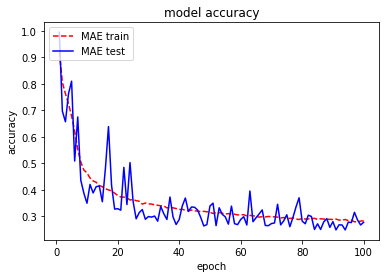

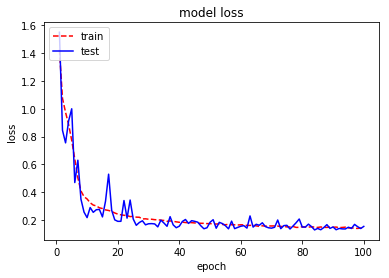

In [30]:
# list all data in history
print(history.history.keys())

# Create count of the number of epochs
nbepocs = range(1, len(training_loss) + 1)

# summarize history for accuracy
plt.plot(nbepocs,training_accuracy,'r--')
plt.plot(nbepocs,test_accuracy, 'b-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['MAE train', 'MAE test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(nbepocs,training_loss,'r--')
plt.plot(nbepocs,test_loss, 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# genere une prediction
prediction = model.predict(X_testNN, batch_size=BATCH_SIZE, verbose=1)

6493/6493 [==============================] - 0s 33us/step


### Pour confronter le modèle sur Kaggle

In [33]:
prediction=[float(i) for i in prediction]
submission = pd.DataFrame({'datetime':df_bike_test['datetime'],'count':prediction})
#submission["count"] = submission["count"].astype(int)
#print(submission)
submission["count"]=np.exp(submission["count"])
cpt_row=0
for row_submisson in submission["count"]:
        #print(submission.loc[[cpt_row], ['count']])
    #submission.loc[[cpt_row], ['count']]=submission.loc[[cpt_row], ['count']]
    if row_submisson<0 :
            submission.loc[[cpt_row], ['count']]=0
    cpt_row=cpt_row+1
 
filename = 'Bike Sharing_NN.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: Bike Sharing_NN.csv


## Fonctions utiles

In [34]:
lst_mae_score=[]
lst_mae_score.append('MAE')
lst_mse_score=[]
lst_mse_score.append('MSE')
lst_rmsle_score=[]
lst_rmsle_score.append('RMSLE')

In [35]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [36]:
from sklearn.metrics.scorer import make_scorer

RMSLE2 = make_scorer(rmsle_score)

In [37]:
df_train, df_test = skl_model_selection.train_test_split(df_combine[0])
#print(df_combine[0].head(2))
X=df_combine[0].iloc[:, 2:27]
Y =df_combine[0]["count"]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# On split le dataset en train-set et test-set
X_train = df_train.iloc[:, 2:27] #27 car 28 et 29 features spécifiques à casuals et registered
#Y_train = df_train["Target"]
Y_train = df_train["count"]
#print(df_train.head())
X_test = df_test.iloc[:, 2:27] #27 car 28 et 29 features spécifiques à casuals et registered
#Y_test = df_test["Target"]
Y_test = df_test["count"]


In [38]:
def format_e(n):
    n=abs(n)
    a = '%E' % n
    return str(round(float(a.split('E')[0].rstrip('0').rstrip('.')),2)) + 'E' + a.split('E')[1]

## Comparaison des différents modèles

In [39]:

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
RFR= RandomForestRegressor()
model=RFR
#score=cross_val_score(RFR, X, Y, cv=5, scoring='mean_squared_error')
lst_mse_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error').mean()))
lst_mae_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_median_absolute_error').mean()))
lst_rmsle_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_log_error').mean()))


C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensem

In [40]:
from sklearn.svm import SVR
model=SVR()
#lR = LogisticRegression()

lst_mse_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error').mean()))
lst_mae_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_median_absolute_error').mean()))
lst_rmsle_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_log_error').mean()))


C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\svm\base.py:

In [41]:
from sklearn import mixture
from sklearn.mixture import GaussianMixture
#lm=LinearRegression()
model = GaussianMixture()
lst_mse_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error').mean()))
lst_mae_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_median_absolute_error').mean()))
lst_rmsle_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_log_error').mean()))


In [42]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
#score=cross_val_score(RFR, X, Y, cv=5, scoring='mean_squared_error')
lst_mse_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error').mean()))
lst_mae_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_median_absolute_error').mean()))
lst_rmsle_score.append(format_e(cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_log_error').mean()))


In [43]:
##NN score:
lst_mse_score.append(round(mseNN,2))
lst_mae_score.append(round(maeNN,2))
lst_rmsle_score.append(round(rmsleNN,2))

In [44]:
from prettytable import PrettyTable
t = PrettyTable(['    ','RandomForestRegressor','SVM Regressor','GaussianMixture','AdaBoostRegressor', 'NeuralNetworks'])
t.add_row(lst_mse_score)
t.add_row(lst_mae_score)
t.add_row(lst_rmsle_score)
print(t)

+-------+-----------------------+---------------+-----------------+-------------------+----------------+
|       | RandomForestRegressor | SVM Regressor | GaussianMixture | AdaBoostRegressor | NeuralNetworks |
+-------+-----------------------+---------------+-----------------+-------------------+----------------+
|  MSE  |        6.4E-06        |    1.96E+00   |     2.29E+01    |      2.4E-02      |      0.15      |
|  MAE  |        8.44E-16       |    8.46E-01   |     5.0E+00     |      1.09E-01     |      0.28      |
| RMSLE |        9.31E-08       |    1.21E-01   |     2.89E+00    |      2.25E-03     |      0.12      |
+-------+-----------------------+---------------+-----------------+-------------------+----------------+


## Pour Kaggle:

In [45]:
X=df_combine[0]
Y =df_combine[0]["count"]
#on  définie les features qui vont être intéressants pour la prédiction
features=X.columns.values
features=list(features)
features.remove("datetime")
features.remove("daypart_casual")
features.remove("daypart_registered")
features.remove("casual")
features.remove("registered")
features.remove("count")

X_train = df_combine[0]
Y_train = df_combine[0]["count"]
X_test = df_combine[1]

In [47]:
RFR= RandomForestRegressor()
RFR.fit(X_train[features],Y_train)
pred = RFR.predict(X_test[features])
submission = pd.DataFrame({'datetime':df_bike_test['datetime'],'count':pred})
#submission["count"] = submission["count"].astype(int)
#print(submission)
submission["count"]=np.exp(submission["count"])
cpt_row=0
for row_submisson in submission["count"]:
        #print(submission.loc[[cpt_row], ['count']])
    #submission.loc[[cpt_row], ['count']]=submission.loc[[cpt_row], ['count']]
    if row_submisson<0 :
            submission.loc[[cpt_row], ['count']]=0
    cpt_row=cpt_row+1
 
filename = 'Bike Sharing.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Saved file: Bike Sharing.csv


## Si on distingue registered et casuals comme vu dans le train set

In [48]:
df_train, df_test = skl_model_selection.train_test_split(df_combine[0])
#print(df_combine[0].head(2))
X=df_combine[0]
Y =df_combine[0]["count"]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [49]:
features_casual=X.columns.values
features_registered=X.columns.values
features_casual=list(features_casual)
features_registered=list(features_registered)
features_casual.remove("datetime")
features_registered.remove("datetime")
features_casual.remove("registered")
features_registered.remove("registered")
features_casual.remove("casual")
features_registered.remove("casual")
features_casual.remove("count")
features_registered.remove("count")
features_casual.remove("daypart_registered")
features_registered.remove("daypart_casual")

In [50]:
X_cas=X_train[features_casual]
Y_cas=X_train['casual']
X_testcas=X_test[features_casual]
X_reg=X_train[features_registered]
Y_reg=X_train['registered']
X_testreg=X_test[features_registered]

In [51]:
from sklearn.model_selection import train_test_split

X_trainreg, X_validreg, Y_trainreg, Y_validreg = train_test_split(X_reg, Y_reg, test_size=0.10, random_state=1)
X_traincas, X_validcas, Y_traincas, Y_validcas = train_test_split(X_cas, Y_cas, test_size=0.10, random_state=1)

In [52]:
#normalisation:
from sklearn.preprocessing import StandardScaler

#### Utilisation de Randomforest en séparant casual et registered et soumission sur Kaggle

In [54]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR

#avec randomforest
model= RandomForestRegressor()
model.fit(X_trainreg,Y_trainreg)
predreg = model.predict(X_testreg)

model.fit(X_traincas,Y_traincas)
predcas = model.predict(X_testcas)

pred=np.exp(predreg)+np.exp(predcas)
submission = pd.DataFrame({'datetime':df_bike_test['datetime'],'count':pred})

submission["count"]=submission["count"]
cpt_row=0
for row_submisson in submission["count"]:
    if row_submisson<0 :
            submission.loc[[cpt_row], ['count']]=0
    cpt_row=cpt_row+1
    
filename = 'Bike Sharingregcas.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

C:\Users\Alexandre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Saved file: Bike Sharingregcas.csv
